# 01. TensorFlow Tutorial 


In [25]:
import tensorflow as tf
from tensorflow.python.framework import ops
#from tf_utils import load_dataset, random_mini_batches, convert_to_one_hot, predict

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
import sklearn
import matplotlib.pyplot as plt
%matplotlib inline

## Read data 

In [69]:
iris = pd.read_csv("data/Iris.csv")
iris.drop('Id',axis=1,inplace=True) # unecessary col

def convert2num(df, col):
    for idx, val in enumerate(df[col].unique()):
        print(val, ' is replaced to', idx)
        df[col] = df[col].replace(val, idx)
    return df

iris = convert2num(iris, 'Species')

Iris-setosa  is replaced to 0
Iris-versicolor  is replaced to 1
Iris-virginica  is replaced to 2


In [70]:
def one_hot_matrix(labels, C):
    """
    Creates a matrix where the i-th row corresponds to the ith class number and the jth column
                     corresponds to the jth training example. So if example j had a label i. Then entry (i,j) will be 1.                
    Arguments:
        labels -- vector containing the labels 
        C -- number of classes, the depth of the one hot dimension
    
    Returns: 
        one_hot -- one hot matrix
    """
    
    C = tf.constant(C, name = "C")
    one_hot_matrix = tf.one_hot(labels, C, axis=0)
    
    with tf.Session() as sess: 
        one_hot = sess.run(one_hot_matrix)

    return one_hot

In [71]:
train, test = train_test_split(iris, test_size = 0.3) # split into train and test
X_train = train[['SepalLengthCm','SepalWidthCm','PetalLengthCm','PetalWidthCm']] # training data features
Y_train=train.Species # target of training data
X_test= test[['SepalLengthCm','SepalWidthCm','PetalLengthCm','PetalWidthCm']] # test data features
Y_test =test.Species   # target of test data

X_train = np.array(X_train, dtype=np.float32).T
Y_train = one_hot_matrix(np.array(Y_train,dtype=np.float32), C = 3)
X_test = np.array(X_test,dtype=np.float32).T
Y_test = one_hot_matrix(np.array(Y_test,dtype=np.float32), C = 3)

m_train = X_train.shape
m_test = X_test.shape

print("Size of:")
print("- Training-set:\t\t{}".format(m_train))
print("- Test-set:\t\t{}".format(m_test))

Size of:
- Training-set:		(4, 105)
- Test-set:		(4, 45)


## 2.1 - Create placeholders

Create placeholders for X and Y. This will allow you to later pass your training data in when you run your session.

In [7]:
def create_placeholders(n_x, n_y):
    """
    Creates the placeholders for the tensorflow session.
    
    Arguments:
        n_x -- scalar, size of an image vector (num_px * num_px = 64 * 64 * 3 = 12288)
        n_y -- scalar, number of classes (from 0 to 5, so -> 6)
    
    Returns:
        X -- placeholder for the data input, of shape [n_x, None] and dtype "float"
        Y -- placeholder for the input labels, of shape [n_y, None] and dtype "float"
    """
    
    X = tf.placeholder(tf.float32, shape=(n_x, None))
    Y = tf.placeholder(tf.float32, shape=(n_y, None))
    
    return X, Y

In [11]:
def initialize_parameters(n_x, n_y, hidden_neurons):
    """
    Initializes parameters to build a neural network with tensorflow
    Returns:
        parameters -- a dictionary of tensors containing W1, b1, W2, b2, W3, b3
    """
    hn1 = hidden_neurons[0]
    hn2 = hidden_neurons[1]
    tf.set_random_seed(1)   # so that your "random" numbers match ours
        
    W1 = tf.get_variable("W1", [hn1, n_x], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    b1 = tf.get_variable("b1", [hn1,1], initializer = tf.zeros_initializer())
    W2 = tf.get_variable("W2", [hn2,hn1], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    b2 = tf.get_variable("b2", [hn2,1], initializer = tf.zeros_initializer())
    W3 = tf.get_variable("W3", [n_y,hn2], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    b3 = tf.get_variable("b3", [n_y,1], initializer = tf.zeros_initializer())

    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2,
                  "W3": W3,
                  "b3": b3}
    
    return parameters

## 2.3 - Forward propagation in tensorflow

In [12]:
def forward_propagation(X, parameters):
    """
    Implements the forward propagation for the model: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SOFTMAX
    
    Arguments:
        X -- input dataset placeholder, of shape (input size, number of examples)
        parameters -- python dictionary containing your parameters "W1", "b1", "W2", "b2", "W3", "b3"
                      the shapes are given in initialize_parameters
    Returns:
        Z3 -- the output of the last LINEAR unit
    """
    
    # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    
    Z1 = tf.add(tf.matmul(W1, X),b1)            # Z1 = np.dot(W1, X) + b1
    A1 = tf.nn.relu(Z1)                         # A1 = relu(Z1)
    Z2 = tf.add(tf.matmul(W2, A1),b2)           # Z2 = np.dot(W2, a1) + b2
    A2 = tf.nn.relu(Z2)                         # A2 = relu(Z2)
    Z3 = tf.add(tf.matmul(W3, A2),b3)           # Z3 = np.dot(W3,Z2) + b3
    
    return Z3

## 2.4 Compute cost

In [13]:
def compute_cost(Z3, Y):
    """
    Computes the cost    
    Arguments:
        Z3 -- output of forward propagation (output of the last LINEAR unit), of shape (6, number of examples)
        Y -- "true" labels vector placeholder, same shape as Z3
    Returns:
        cost - Tensor of the cost function
    """
    
    # to fit the tensorflow requirement for tf.nn.softmax_cross_entropy_with_logits(...,...)
    logits = tf.transpose(Z3)
    labels = tf.transpose(Y)   
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels))    
    return cost

## 2.5 - Backward propagation & parameter updates

## 2.6 - Building the model

In [51]:
def model(X_train, Y_train, X_test, Y_test, hidden_neurons=[25,12], learning_rate = 0.0001,
          num_epochs = 1500, minibatch_size = 32, print_cost = True):
    """
    Implements a three-layer tensorflow neural network: LINEAR->RELU->LINEAR->RELU->LINEAR->SOFTMAX.
    
    Arguments:
        X_train -- training set, of shape (input size, number of training examples)
        Y_train -- test set, of shape (output size, number of training examples)
        X_test -- training set, of shape (input size, number of training examples)
        Y_test -- test set, of shape (output size, number of test examples)
        learning_rate -- learning rate of the optimization
        num_epochs -- number of epochs of the optimization loop
        minibatch_size -- size of a minibatch
        print_cost -- True to print the cost every 100 epochs
    
    Returns:
        parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    tf.set_random_seed(1)                             # to keep consistent results
    seed = 3                                          # to keep consistent results
    (n_x, m) = X_train.shape                          # (n_x: input size, m : number of examples in the train set)
    n_y = Y_train.shape[0]                            # n_y : output size
    costs = []                                        # To keep track of the cost
    
    X, Y = create_placeholders(n_x, n_y) # Create Placeholders of shape (n_x, n_y)

    parameters = initialize_parameters(n_x, n_y, hidden_neurons) # Initialize parameters
    Z3 = forward_propagation(X, parameters) # Forward propagation: Build the forward propagation in the tensorflow graph
    cost = cost = compute_cost(Z3, Y) # Cost function: Add cost function to tensorflow graph
    
    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer.
    optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate).minimize(cost) 
    init = tf.global_variables_initializer()     # Initialize all the variables

    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
         
        sess.run(init)     # Run the initialization
        for epoch in range(num_epochs): # Do the training loop

            epoch_cost = 0.             
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            seed = seed + 1
            
            _ , minibatch_cost = sess.run([optimizer, cost], feed_dict={X: X_train, Y: Y_train})
            epoch_cost += minibatch_cost / num_minibatches

            # Print the cost every epoch
            if print_cost == True and epoch % 100 == 0:
                print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
            costs.append(epoch_cost)
                
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # lets save the parameters in a variable
        parameters = sess.run(parameters)
        print ("Parameters have been trained!")

        # Calculate the correct predictions
        correct_prediction = tf.equal(tf.argmax(Z3), tf.argmax(Y))

        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

        print ("Train Accuracy:", accuracy.eval({X: X_train, Y: Y_train}))
        print ("Test Accuracy:", accuracy.eval({X: X_test, Y: Y_test}))
        
        return parameters, correct_prediction

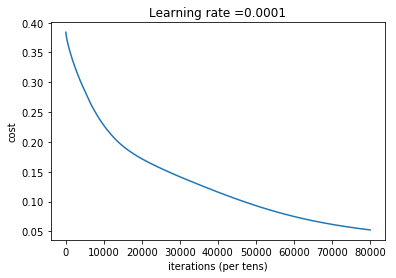

Parameters have been trained!
Train Accuracy: 0.971429
Test Accuracy: 0.977778


In [74]:
parameters = model(X_train, Y_train, X_test, Y_test, hidden_neurons =[30,10], num_epochs = 80000, print_cost = False)

## Using Polynomial Features

In [36]:
train, test = train_test_split(iris, test_size = 0.3) # split into train and test
X_train = train[['SepalLengthCm','SepalWidthCm','PetalLengthCm','PetalWidthCm']] # training data features
Y_train=train.Species # target of training data
X_test= test[['SepalLengthCm','SepalWidthCm','PetalLengthCm','PetalWidthCm']] # test data features
Y_test =test.Species   # target of test data

# polynomial features degree-n polynomial features are [1, a, b, a^2, ab, b^2].
poly = PolynomialFeatures(2)

X_train = poly.fit_transform(np.array(X_train, dtype=np.float32)).T
Y_train = one_hot_matrix(np.array(Y_train,dtype=np.float32), C = 3)
X_test  = poly.fit_transform(np.array(X_test,dtype=np.float32)).T
Y_test = one_hot_matrix(np.array(Y_test,dtype=np.float32), C = 3)

m_train = X_train.shape
m_test = X_test.shape

print("Size of:")
print("- Training-set:\t\t{}".format(m_train))
print("- Test-set:\t\t{}".format(m_test))

Size of:
- Training-set:		(15, 105)
- Test-set:		(15, 45)


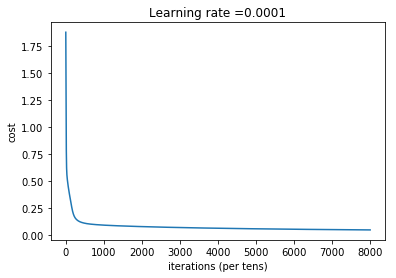

Parameters have been trained!
Train Accuracy: 0.971429
Test Accuracy: 0.977778


In [52]:
(parameters, prediction) = model(X_train, Y_train, X_test, Y_test, hidden_neurons =[30, 20], num_epochs = 8000, print_cost = False)

In [64]:
with tf.Session() as sess:
    print(sess.run(tf.argmax(forward_propagation(X_test, parameters))))
    print(sess.run(tf.argmax(Y_test)))

[0 0 1 2 2 2 0 0 2 2 0 1 1 0 1 2 2 0 1 2 0 1 1 2 0 1 1 2 1 1 1 2 0 2 2 0 1
 2 0 1 2 1 0 0 1]
[0 0 1 2 2 2 0 0 2 2 0 1 1 0 1 2 2 0 1 2 0 1 1 2 0 1 1 2 1 1 1 1 0 2 2 0 1
 2 0 1 2 1 0 0 1]
